# Basics Tutorial for Snorkel MeTaL

The purpose of this tutorial is to introduce the basic models and debugging/analysis tools provided by Snorkel MeTaL. In this notebook, we'll investigate a single-task problem with synthetic data, with an emphasis on the basic design concepts of MeTaL. Additional tutorials in the `tutorials/` directory provide further details on topics such as hyperparameter tuning, multi-task problems, and customization of the EndModel (e.g., using an LSTM input module).

This tutorial consists of four steps:
1. Load Data
2. Train Label Model
3. Train End Model
4. Evaluate

Let's get started!

### Setup
We first need to make sure that the `metal/` directory is on our Python path. If the following cell runs without an error, you're all set. If not, make sure that you've installed `snorkel-metal` with pip or conda (or that you've added the repo to your path if you're running from source; for example, running `source add_to_path.sh` from the repository root).

In [1]:
import metal

## Step 1: Load Data

The first step in a Snorkel MeTaL application is preparing your data.

### Concept 1: Required Data Types

In particular, MeTaL makes use of the following types of data (n = # examples, m = # labeling functions):
* X: an \[n\]-dim iterable of end model inputs (e.g., feature vectors or encoded sentences for an RNN)
* Y: an \[n\]-dim numpy.ndarray of target labels ($Y \in \{1,...,k\}^n$)
* L: an \[n,m\] scipy.sparse matrix of noisy labels ($L \in \{0,...,k\}^{n \times m}$, with label 0 reserved for abstentions

And optionally (for use with some debugging/analysis tools):
* D: an \[n\]-dim iterable of human-readable examples (e.g., sentences)

In this tutorial, we use pre-generated synthetic data, where each example is a bag of words drawn from a different gaussian distribution for each class from a 1000-word vocabulary, and our features are simply the 1000-dimensional vector of counts for each word. For some excellent resources on how to write labeling functions, see the Snorkel tutorials at https://github.com/HazyResearch/snorkel/tree/master/tutorials.

In [2]:
import pickle

with open("data/basics_tutorial.pkl", 'rb') as f:
    X, Y, L, D = pickle.load(f)

If you need to divide your data into splits, you can do so with the provided utility function. We split our data 80/10/10 into train/dev/test, stratifying by the labels in `Y` to ensure a similar class balance in each split.

In [3]:
from metal.utils import split_data

Xs, Ys, Ls, Ds = split_data(X, Y, L, D, splits=[0.8, 0.1, 0.1], stratify_by=Y, seed=123)

### Investigate Label Matrices

MeTaL comes with a number of analysis tools for investigating your label matrix. 
For example, you can view summary statistics for each labeling function.
If you have a dev set with gold labels, you can view the empirical accuracy of your functions, in addition to the core summary statistics such as coverage, overlaps, and conflicts.

In [4]:
from metal.analysis import lf_summary

lf_summary(Ls[1], Y=Ys[1])

,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
0,"[1, 2]",0.700,0.700,0.655,374,326,0.534286
1,"[1, 2]",0.735,0.735,0.700,468,267,0.636735
2,"[1, 2]",0.744,0.744,0.701,500,244,0.672043
3,"[1, 2]",0.748,0.748,0.706,540,208,0.721925
4,"[1, 2]",0.719,0.719,0.675,454,265,0.631433
5,"[1, 2]",0.746,0.746,0.696,457,289,0.612601
6,"[1, 2]",0.762,0.762,0.728,509,253,0.667979
7,"[1, 2]",0.796,0.796,0.744,593,203,0.744975
8,"[1, 2]",0.811,0.811,0.756,642,169,0.791615
9,"[1, 2]",0.784,0.784,0.735,559,225,0.713010


Or, if you prefer a graphical view, you can generate heat maps of the label matrix or overlaps/conflicts. In this case, there isn't a lot to see, since these label matrices were created synthetically. However, these visualizations can often help you to discover unexpected phenomena in your label matrices, such as unexpectedly high or low conflict rates between certain labeling functions, or portions of your dataset with surprisingly low or high coverage.

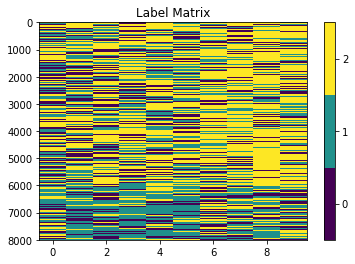

In [5]:
from metal.analysis import view_label_matrix, view_overlaps

view_label_matrix(Ls[0])

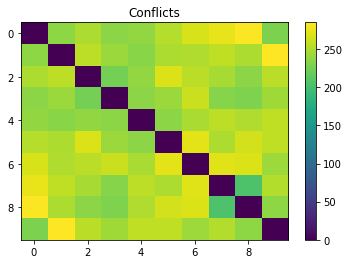

In [6]:
from metal.analysis import view_conflicts
view_conflicts(Ls[1], normalize=False)

Once you're satisfied with our label matrices, it's time to aggregate the labels using the label model and train an end model with the resulting probabilistic labels.

## Step 2: Train Label Model

### Concept: Config dicts

All Snorkel MeTaL models are driven by configuration dictionaries, or config dicts; that is, all settings for running the given model are stored in a single dictionary, `self.config`. 

When a model is initialized or the train() method is called, any extra keyword arguments passed by the user will be used to update the config dict. Then, throughout the class's methods, whenever a setting needs to be looked up, it is pulled from this dictionary, rather than required as a keyword. This has a number of benefits:

1. Default values are stored in only one place, the default config dict, rather than in multiple method signatures.
1. Code maintenance is simplified, since fewer keyword arguments need to be passed up and down the call stack.
2. Logging is simplified, since the complete settings for a given model can be logged by simply writing the config dict (a python dictionary) to file.

### Label Model

When constructing a LabelModel, the only required argument is `k`, the cardinality of the task. For example, k=2 means a binary classification task.

In [7]:
from metal.label_model import LabelModel
label_model = LabelModel(k=2, seed=123)

The only required argument to `LabelModel.train()` is a label matrix. All other keyword arguments are optional. 

For example, if you know the class_balance of our data, you can pass that in as a list or array; alternatively, you may pass in the target labels of your dev set (`Y_dev`) and have the class balance estimated from that. If neither of these is provided, the classes are assumed to be uniformly distributed.

Any other keyword arguments (e.g., the number of epochs (`n_epochs`), learning rate (`lr`), optimizer type (`optimizer`), etc.) will be used to update the config dict.

In [8]:
%%time
label_model.train(Ls[0], Y_dev=Ys[1], n_epochs=100, print_every=25)

Computing O...
Estimating \mu...
[E:0]	Train Loss: 6.273
[E:25]	Train Loss: 0.271
[E:50]	Train Loss: 0.020
[E:75]	Train Loss: 0.005
[E:99]	Train Loss: 0.002
Finished Training
CPU times: user 171 ms, sys: 12.3 ms, total: 184 ms
Wall time: 51.4 ms


You can test the quality of our label model on our dev set as a sanity check, but we'll see if we can do better in Step 3 by using the predictions of the label model to train a discriminative model over a larger feature set than just the outputs of these ten labeling functions.

In [9]:
score = label_model.score(Ls[1], Ys[1])

Accuracy: 0.889


By default, the score method reports accuracy, but you can also give it a list of metrics to report. Depending on your application, F1 score may be a more natural metric to use, especially if you have large class imbalance. Our synthetic data, for example, has an approximate 25/75 split.

In [10]:
scores = label_model.score(Ls[1], Ys[1], metric=['precision', 'recall', 'f1'])

Precision: 0.833
Recall: 0.687
F1: 0.753


We can see that our trained model outperforms the baseline of just taking the majority vote label by approximately 4 F1 points on the dev set.

In [11]:
from metal.label_model.baselines import MajorityLabelVoter

mv = MajorityLabelVoter(seed=123)
scores = mv.score(Ls[1], Ys[1], metric=['precision', 'recall', 'f1'])

Precision: 0.623
Recall: 0.841
F1: 0.716


### Concept: Classifier Base Class

Both the `LabelModel` and `EndModel` in MeTaL are children of the parent `Classifier` class. The `Classifier` class defines three important methods related to making predictions:
* `predict_proba()`: Returns an [n, k+1] numpy array of probabilistic labels (k+1 because of the option to abstain)
* `predict()`: Returns an [n]-dim numpy array of hard (integer) labels in {0,...,k+1}
* `score()`: Returns the score (default: accuracy) of the predictions with respect to target labels

Following the data programming paradigm, we will use our label model's soft predictions as training labels for a discriminative end model. Because we want probabilistic labels, we use the `predict_proba()` method here. The predictions are in the form of an [n,k] np.ndarray of floats summing to 1.0 in each row, where `Y_ps[i,j]` is the predicted probability of the $i$th data point having true label $j$.

In [12]:
Y_train_ps = label_model.predict_proba(Ls[0])
# Y_train_ps stands for "Y[labels]_train[split]_p[redicted]s[oft]"
Y_train_ps

array([[0.2649789 , 0.7350211 ],
       [0.00867136, 0.99132864],
       [0.01536846, 0.98463154],
       ...,
       [0.60597746, 0.39402254],
       [0.9802152 , 0.0197848 ],
       [0.278771  , 0.721229  ]])

### Analysis tools

At this point, we may want to analyze our LabelModel's predictions so that we better understand what our model is learning.

First, we observe that our problem has a severe class imbalance, which our classifier captures in a general sense.

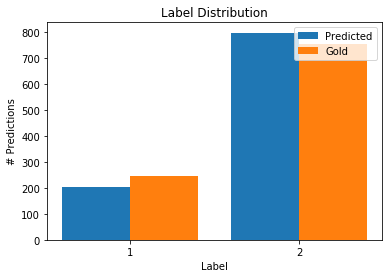

In [13]:
from metal.analysis import plot_predictions_histogram

Y_dev_p = label_model.predict(Ls[1])
plot_predictions_histogram(Y_dev_p, Ys[1], title="Label Distribution")

Similarly, we can look at how confident our model is in its predictions for class 1 and see that most have probabilities very close to 0.

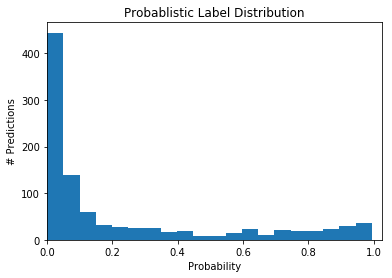

In [14]:
from metal.analysis import plot_probabilities_histogram

Y_dev_ps = label_model.predict_proba(Ls[1])
plot_probabilities_histogram(Y_dev_ps[:,0], title="Probablistic Label Distribution")

If we want exact counts, we can print out a confusion matrix.

In [15]:
from metal.analysis import confusion_matrix

cm = confusion_matrix(Ys[1], Y_dev_p)

        y=1    y=2   
 l=1    169    77    
 l=2    34     720   


## Step 3: Train End Model

We will now construct and train our `EndModel` on the predictions from the LabelModel. Here we describe the construction of a single-task end model. For details on the construction of multi-task end models, refer to the multi-task tutorial.

The `EndModel` consists of three components: an *input layer*, zero or more *middle layers*, and a *head layer*, with each layer consisting of a torch.nn.Module followed by various optional additional operators (e.g., a ReLU nonlinearity, batch normalization, and/or dropout). 

* **Input layer**:
The input module an IdentityModule by default, which simply accepts arbitrary-length feature vectors from X as torch.Tensors and passes them on to the next module in the network. If, however, you would like provide your data in some other format, you may pass in a custom nn.Module which maps your input type to torch.Tesnors (for example, if your data points are images, you may pass in a ResNet as your input module).

* **Middle layers**
The middle layers are layers between the input layer and head layer. Middle modules are nn.Linear by default.

* **Head layer**:
The head layer is the final layer, consisting of an nn.Linear module (plus a softmax operation when making predictions).
 
When initiated, the EndModel requires a list of output dimensions. 
The first element is the output dimension of the input module (which is equal to the dimensionality of your feature vectors if using the default Identitymodule).
The last element is the cardinality of the classifier.
The elements in the middle define the number and dimensionality of any middle layers.

In [16]:
from metal.end_model import EndModel

end_model = EndModel([1000,10,2], seed=123)


Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=1000, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Linear(in_features=10, out_features=2, bias=True)
)



Once initiated, the network structure is printed so you can confirm that it captured the architecture you want.

To train the model, we pass in our unlabeled training data, our predicted soft labels from the label aggregator, a dev set X and Y if we want to checkpoint the best model seen so far as we train, and any other keyword arguments that you'd like to update in the config dict. For this synthetic problem, the trends in our data are fairly simple, so our model will begin to overfit very quickly. If we do begin to overfit and see our dev score go down, however, the best model seen at any epoch will be restored at the end of training.

In [17]:
end_model.train(Xs[0], Y_train_ps, Xs[1], Ys[1], l2=0.1, batch_size=256, 
                n_epochs=5, print_every=1, validation_metric='f1')

Saving model at iteration 0 with best score 0.981
[E:0]	Train Loss: 0.460	Dev score: 0.981
[E:1]	Train Loss: 0.418	Dev score: 0.926
[E:2]	Train Loss: 0.412	Dev score: 0.935
[E:3]	Train Loss: 0.409	Dev score: 0.929
[E:4]	Train Loss: 0.407	Dev score: 0.915
Restoring best model from iteration 0 with score 0.981
Finished Training
Confusion Matrix (Dev)
        y=1    y=2   
 l=1    238     1    
 l=2     8     753   


## Step 4: Evaluate

With a trained EndModel, we can now evaluate performance on our held-out test set, observing a substantial boost in F1 score over using the LabelModel directly.

In [18]:
print("Label Model:")
score = label_model.score(Ls[2], Ys[2], metric=['precision', 'recall', 'f1'])
print()
print("End Model:")
score = end_model.score(Xs[2], Ys[2], metric=['precision', 'recall', 'f1'])

Label Model:
Precision: 0.819
Recall: 0.626
F1: 0.710

End Model:
Precision: 0.996
Recall: 0.967
F1: 0.981


And there you go! If you'd like to learn about some of the other features in Snorkel MeTaL, including support for multi-task learning (MTL), hyperparameter tuning, and synthetic data generation, give some of the other tutorial notebooks a try!